## mmdetection에서 albu 라이브러리 적용하는 방법
    - retinanet_18 기준인데 우리는 faster_rcnn으로 바꿨음

### 1. mmdetection > configs > base > datasets > mybus.py을 생성

### 2. 데이터 세팅하기
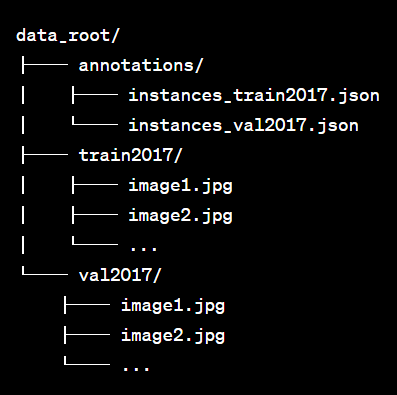

In [9]:
dataset_type = 'CocoDataset'
data_root = '데이터셋 경로. 예시: data/' #이미지 파일이랑 json 파일이 같은 폴더에 있어야 함, 위에 사진처럼.
backend_args = None #데이터셋 파일 로딩을 위한 백엔드 설정. 현재는 사용되지 않으므로 None으로 설정
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

In [ ]:
_base_ = '../faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py' #이거 faster rcnn 으로 설정

albu_train_transforms = [
    dict(
        type='ShiftScaleRotate',
        shift_limit=0.0625,
        scale_limit=0.0,
        rotate_limit=0,
        interpolation=1,
        p=0.5),
    dict(
        type='RandomBrightnessContrast',
        brightness_limit=[0.1, 0.3],
        contrast_limit=[0.1, 0.3],
        p=0.2),
    dict(
        type='OneOf',
        transforms=[
            dict(
                type='RGBShift',
                r_shift_limit=10,
                g_shift_limit=10,
                b_shift_limit=10,
                p=1.0),
            dict(
                type='HueSaturationValue',
                hue_shift_limit=20,
                sat_shift_limit=30,
                val_shift_limit=20,
                p=1.0)
        ],
        p=0.1),
    dict(type='JpegCompression', quality_lower=85, quality_upper=95, p=0.2),
    dict(type='ChannelShuffle', p=0.1),
    dict(
        type='OneOf',
        transforms=[
            dict(type='Blur', blur_limit=3, p=1.0),
            dict(type='MedianBlur', blur_limit=3, p=1.0)
        ],
        p=0.1),
]
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(
        type='Albu',
        transforms=albu_train_transforms,
        bbox_params=dict(
            type='BboxParams',
            format='pascal_voc',
            label_fields=['gt_bboxes_labels', 'gt_ignore_flags'],
            min_visibility=0.0,
            filter_lost_elements=True),
        keymap={
            'img': 'image',
            'gt_masks': 'masks',
            'gt_bboxes': 'bboxes'
        },
        skip_img_without_anno=True),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackDetInputs')
]

train_dataloader = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    persistent_workers=True,
    shuffle=True,
    dataset=dict(
        type=dataset_type,
        ann_file=data_root + 'annotation 파일 경로',
        img_prefix=data_root + '이미지 파일 경로. 예시: train2017/',
        pipeline=train_pipeline,
        backend_args=backend_args))

# ---------------------------------------------------------------------------------------------------------------

### 3. 파이프라인 정의하기

In [3]:
# 훈련 데이터 전처리 파이프라인
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='Pad', size_divisor=32),
    
    dict(type='Normalize', **img_norm_cfg),
    dict(type='DefaultFormatBundle'),
    dict(
        type='Collect',
        keys=['img', 'gt_bboxes', 'gt_labels'],
        meta_keys=('filename', 'ori_shape', 'img_shape', 'img_norm_cfg', 'pad_shape', 'scale_factor'))
]
# 테스트 데이터 전처리 파이프라인
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

### 4. 데이터로더 설정하기

In [6]:
train_dataloader = dict(
    batch_size=2, # batch size: 한 번에 처리할 데이터 샘플의 개수
    num_workers=2, # 데이터 로딩을 병렬화하기 위해 사용되는 워커의 수. 워커는 데이터를 미리 로딩하고 전처리하여 모델에 제공하는 역할을 수행
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=True),
    batch_sampler=dict(type='AspectRatioBatchSampler'),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        ann_file='annotation 파일 경로 쓰기. 예시: annotations/instances_train2017.json',
        data_prefix=dict(img='train 이미지 경로 쓰기. 예시: train2017/'),
        filter_cfg=dict(filter_empty_gt=True, min_size=32),
        pipeline=train_pipeline,
        backend_args=backend_args))

val_dataloader = dict(
    batch_size=1,
    num_workers=2,
    persistent_workers=True,
    drop_last=False, # True로 설정하면 배치 크기에 맞지 않는 마지막 배치를 무시(drop), False로 설정하면 마지막 배치를 유지.
    sampler=dict(type='DefaultSampler', shuffle=False), # shuffle=True로 설정하면 데이터를 임의로 섞어서 전달함.
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        ann_file='annotation 파일 경로',
        data_prefix=dict(img='validation 이미지 경로 쓰기'),
        test_mode=True,
        pipeline=test_pipeline,
        backend_args=backend_args))

test_dataloader = val_dataloader


### 5. 성능 평가

In [7]:
val_evaluator = dict(
    type='CocoMetric',
    ann_file=data_root + 'annotation 파일 경로',
    metric='bbox',
    format_only=False,
    backend_args=backend_args)

test_evaluator = val_evaluator